# （3）在多分类任务实验中实现momentum、rmsprop、adam优化器
+ 在手动实现多分类的任务中手动实现三种优化算法，并补全Adam中计算部分的内容
+ 在torch.nn实现多分类的任务中使用torch.nn实现各种优化器，并对比其效果

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# 数据预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

In [ ]:
# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 1. Adam

In [ ]:
# Adam优化器初始化
def init_adam_states(params):
    v_w1, v_b1, v_w2, v_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape), \
                              torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    s_w1, s_b1, s_w2, s_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape), \
                              torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    return [(v_w1, s_w1), (v_b1, s_b1), (v_w2, s_w2), (v_b2, s_b2)]

def adam(params, states, lr, t, beta1=0.9, beta2=0.999, eps=1e-6):
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            
            v_hat = v / (1 - beta1 ** t)
            s_hat = s / (1 - beta2 ** t)
            
            p[:] -= lr * v_hat / (torch.sqrt(s_hat) + eps)
            p.grad.data.zero_()
    t += 1
    return t

## 2. RMSprop

In [ ]:
# RMSprop优化器初始化
def init_rmsprop_states(params):
    return [torch.zeros_like(p) for p in params]

def rmsprop(params, states, lr, gamma, eps=1e-6):
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= lr * p.grad / torch.sqrt(s + eps)
            p.grad.data.zero_()

## 3. Momentum

In [ ]:
# Momentum优化器初始化
def init_momentum_states(params):
    return [torch.zeros_like(p) for p in params]

def sgd_momentum(params, states, lr, momentum):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = momentum * v - p.grad
            p[:] += lr * v
            p.grad.data.zero_()

In [ ]:
# 训练模型函数
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, lr=0.001, momentum=0.9, gamma=0.9, optimizer_type='adam'):
    model.train()
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    # 初始化优化器状态
    if optimizer_type == 'adam':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_adam_states(params)
        t = 1
    elif optimizer_type == 'rmsprop':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_rmsprop_states(params)
    elif optimizer_type == 'momentum':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_momentum_states(params)
    
    # 训练循环
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            if optimizer is not None:
                optimizer.zero_grad()  # 清除梯度，只有在使用torch.optim优化器时
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向传播
            
            # 使用手动优化器更新权重
            if optimizer_type == 'adam':
                t = adam(params, states, lr, t)
            elif optimizer_type == 'rmsprop':
                rmsprop(params, states, lr, gamma)
            elif optimizer_type == 'momentum':
                sgd_momentum(params, states, lr, momentum)
                
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # 计算测试集的loss和准确率
        test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss: {avg_train_loss:12.5f} | "
              f"test loss: {test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")
        
    return train_losses, train_accuracies, test_losses, test_accuracies



Training with adam optimizer:
epoch:  1 | train loss:      0.42038 | test loss:      0.22979 | train acc: 87.86 | test acc: 93.21
epoch:  2 | train loss:      0.21473 | test loss:      0.17705 | train acc: 93.67 | test acc: 94.93
epoch:  3 | train loss:      0.16188 | test loss:      0.14282 | train acc: 95.15 | test acc: 95.70
epoch:  4 | train loss:      0.13070 | test loss:      0.13455 | train acc: 96.00 | test acc: 95.86
epoch:  5 | train loss:      0.11030 | test loss:      0.10770 | train acc: 96.59 | test acc: 96.84
epoch:  6 | train loss:      0.09523 | test loss:      0.10673 | train acc: 97.06 | test acc: 96.76
epoch:  7 | train loss:      0.08480 | test loss:      0.10044 | train acc: 97.38 | test acc: 96.87
epoch:  8 | train loss:      0.07621 | test loss:      0.10219 | train acc: 97.62 | test acc: 96.88
epoch:  9 | train loss:      0.06842 | test loss:      0.09544 | train acc: 97.85 | test acc: 97.23
epoch: 10 | train loss:      0.06001 | test loss:      0.09354 | trai

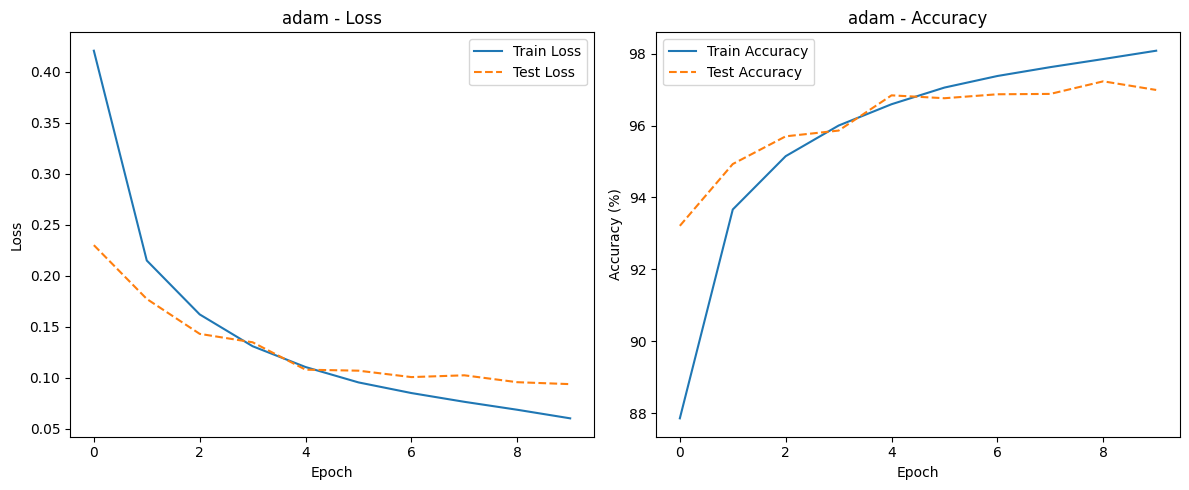


Training with rmsprop optimizer:
epoch:  1 | train loss:      0.38025 | test loss:      0.36913 | train acc: 90.70 | test acc: 90.23
epoch:  2 | train loss:      0.21731 | test loss:      0.16406 | train acc: 94.11 | test acc: 96.05
epoch:  3 | train loss:      0.19937 | test loss:      0.24200 | train acc: 94.84 | test acc: 94.68
epoch:  4 | train loss:      0.19627 | test loss:      0.23865 | train acc: 95.08 | test acc: 94.30
epoch:  5 | train loss:      0.19145 | test loss:      0.18018 | train acc: 95.33 | test acc: 95.57
epoch:  6 | train loss:      0.19962 | test loss:      0.41239 | train acc: 95.28 | test acc: 92.55
epoch:  7 | train loss:      0.20357 | test loss:      0.27504 | train acc: 95.28 | test acc: 94.78
epoch:  8 | train loss:      0.20609 | test loss:      0.23655 | train acc: 95.36 | test acc: 95.47
epoch:  9 | train loss:      0.20816 | test loss:      0.39511 | train acc: 95.39 | test acc: 93.89
epoch: 10 | train loss:      0.20814 | test loss:      0.38449 | t

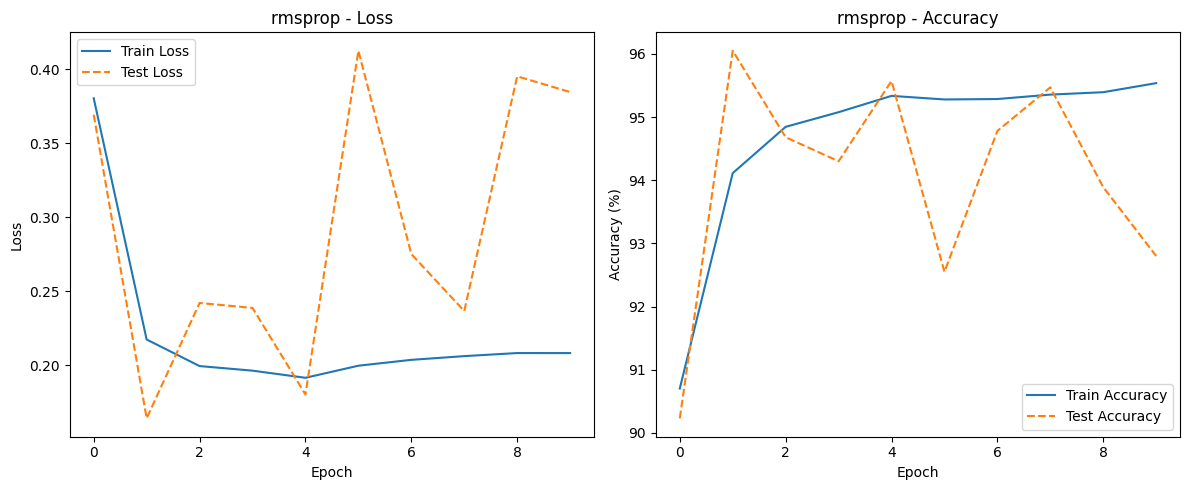


Training with momentum optimizer:
epoch:  1 | train loss:      3.87098 | test loss:      0.27080 | train acc: 94.33 | test acc: 94.06
epoch:  2 | train loss:      0.13455 | test loss:      0.18761 | train acc: 96.73 | test acc: 96.09
epoch:  3 | train loss:      0.10305 | test loss:      0.18851 | train acc: 97.36 | test acc: 96.40
epoch:  4 | train loss:      0.08701 | test loss:      0.17182 | train acc: 97.66 | test acc: 96.43
epoch:  5 | train loss:      0.07566 | test loss:      0.17831 | train acc: 97.83 | test acc: 96.30
epoch:  6 | train loss:      0.06852 | test loss:      0.17411 | train acc: 98.03 | test acc: 96.69
epoch:  7 | train loss:      0.06137 | test loss:      0.17738 | train acc: 98.22 | test acc: 96.55
epoch:  8 | train loss:      0.05423 | test loss:      0.17585 | train acc: 98.36 | test acc: 96.64
epoch:  9 | train loss:      0.04875 | test loss:      0.16720 | train acc: 98.53 | test acc: 96.86
epoch: 10 | train loss:      0.04503 | test loss:      0.17804 | 

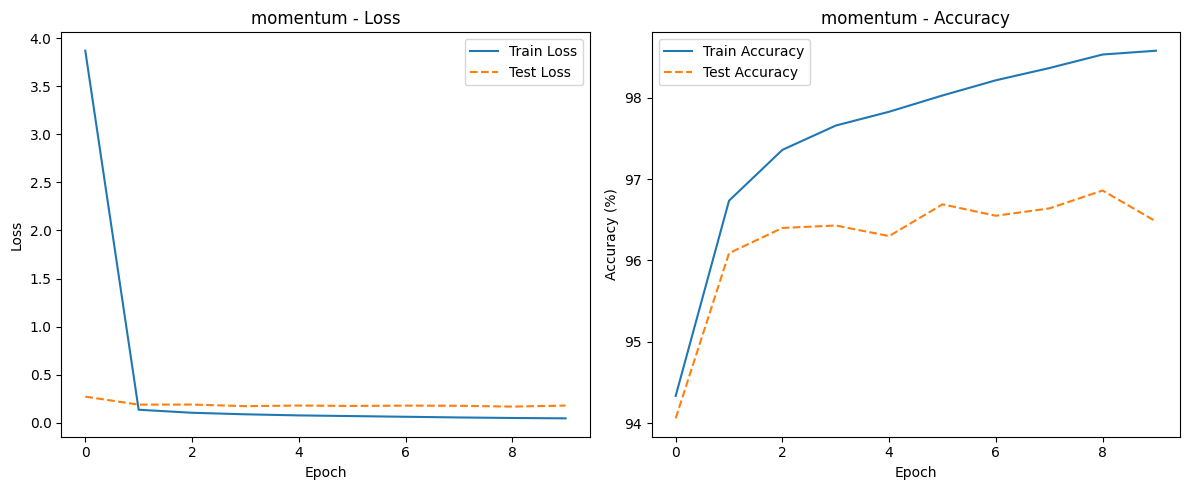

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 数据预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Adam优化器初始化
def init_adam_states(params):
    v_w1, v_b1, v_w2, v_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape), \
                              torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    s_w1, s_b1, s_w2, s_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape), \
                              torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    return [(v_w1, s_w1), (v_b1, s_b1), (v_w2, s_w2), (v_b2, s_b2)]

def adam(params, states, lr, t, beta1=0.9, beta2=0.999, eps=1e-6):
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            
            v_hat = v / (1 - beta1 ** t)
            s_hat = s / (1 - beta2 ** t)
            
            p[:] -= lr * v_hat / (torch.sqrt(s_hat) + eps)
            p.grad.data.zero_()
    t += 1
    return t

# RMSprop优化器初始化
def init_rmsprop_states(params):
    return [torch.zeros_like(p) for p in params]

def rmsprop(params, states, lr, gamma, eps=1e-6):
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= lr * p.grad / torch.sqrt(s + eps)
            p.grad.data.zero_()

# Momentum优化器初始化
def init_momentum_states(params):
    return [torch.zeros_like(p) for p in params]

def sgd_momentum(params, states, lr, momentum):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = momentum * v - p.grad
            p[:] += lr * v
            p.grad.data.zero_()

# 训练模型函数
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, lr=0.001, momentum=0.9, gamma=0.9, optimizer_type='adam'):
    model.train()
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    # 初始化优化器状态
    if optimizer_type == 'adam':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_adam_states(params)
        t = 1
    elif optimizer_type == 'rmsprop':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_rmsprop_states(params)
    elif optimizer_type == 'momentum':
        params = [model.fc1.weight, model.fc1.bias, model.fc2.weight, model.fc2.bias]
        states = init_momentum_states(params)
    
    # 训练循环
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            if optimizer is not None:
                optimizer.zero_grad()  # 清除梯度，只有在使用torch.optim优化器时
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向传播
            
            # 使用手动优化器更新权重
            if optimizer_type == 'adam':
                t = adam(params, states, lr, t)
            elif optimizer_type == 'rmsprop':
                rmsprop(params, states, lr, gamma)
            elif optimizer_type == 'momentum':
                sgd_momentum(params, states, lr, momentum)
                
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # 计算测试集的loss和准确率
        test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss: {avg_train_loss:12.5f} | "
              f"test loss: {test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")
        
    return train_losses, train_accuracies, test_losses, test_accuracies


# 测试模型
def evaluate_model(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return avg_test_loss, test_accuracy


# 创建模型和损失函数
model = SimpleNN()
criterion = nn.CrossEntropyLoss()

# 使用手动实现的优化器训练并评估
optimizers = ['adam', 'rmsprop', 'momentum']
train_results = {}

for opt in optimizers:
    print(f"\nTraining with {opt} optimizer:")
    if opt == 'adam':
        lr = 0.001
    elif opt == 'rmsprop':
        lr = 0.01
    else:
        lr = 0.1
    
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, criterion, None, train_loader, test_loader, epochs=10, lr=lr, optimizer_type=opt)
    train_results[opt] = (train_losses, train_accuracies, test_losses, test_accuracies)

    # 可视化训练损失和准确率
    plt.figure(figsize=(12, 5))
    
    # Train loss & Test loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss', linestyle='--')
    plt.title(f'{opt} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Train accuracy & Test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
    plt.title(f'{opt} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()